In [2]:
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%qtconsole --colors=linux
plt.style.use('ggplot')

from matplotlib import gridspec
from theano import tensor as tt
from scipy import stats

# Chapter 18 - Heuristic decision-making

## 18.1 Take-the-best
The take-the-best (TTB) model of decision-making (Gigerenzer & Goldstein, 1996) is a simple but influential account of how people choose between two stimuli on some criterion, and a good example of the general class of heuristic decision-making models (e.g., Gigerenzer & Todd, 1999; Gigerenzer & Gaissmaier, 2011; Payne, Bettman, & Johnson, 1990).


$$ t_q = \text{TTB}_{s}(\mathbf a_q,\mathbf b_q)$$
$$ \gamma \sim \text{Uniform}(0.5,1)$$  
$$ y_{iq} \sim
\begin{cases}
\text{Bernoulli}(\gamma) & \text{if $t_q = a$} \\
\text{Bernoulli}(1- \gamma) & \text{if $t_q = b$} \\
\text{Bernoulli}(0.5) & \text{otherwise}
\end{cases}  $$

In [3]:
import scipy.io as sio
matdata = sio.loadmat('data/StopSearchData.mat')

y = np.squeeze(matdata['y'])
m = np.squeeze(np.float32(matdata['m']))
p = np.squeeze(matdata['p'])
v = np.squeeze(np.float32(matdata['v']))
x = np.squeeze(np.float32(matdata['x']))

# Constants
n, nc = np.shape(m)  # number of stimuli and cues
nq, _ = np.shape(p)  # number of questions
ns, _ = np.shape(y)  # number of subjects

In [4]:
s = np.argsort(v)  # s[1:nc] <- rank(v[1:nc])
t = []
# TTB Model For Each Question
for q in range(nq):
    # Add Cue Contributions To Mimic TTB Decision
    tmp1 = np.zeros(nc)
    for j in range(nc):
        tmp1[j] = (m[p[q, 0]-1, j]-m[p[q, 1]-1, j])*np.power(2, s[j])
    # Find if Cue Favors First, Second, or Neither Stimulus
    tmp2 = np.sum(tmp1)
    tmp3 = -1*np.float32(-tmp2 > 0)+np.float32(tmp2 > 0)
    t.append(tmp3+1)
t = np.asarray(t, dtype=int)
tmat = np.tile(t[np.newaxis, :], (ns, 1))

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
  0%|          | 0/200000 [00:00<?, ?it/s]Median ELBO converged.
Finished [100%]: Average ELBO = -353.72

100%|██████████| 3000/3000.0 [00:02<00:00, 1022.40it/s]


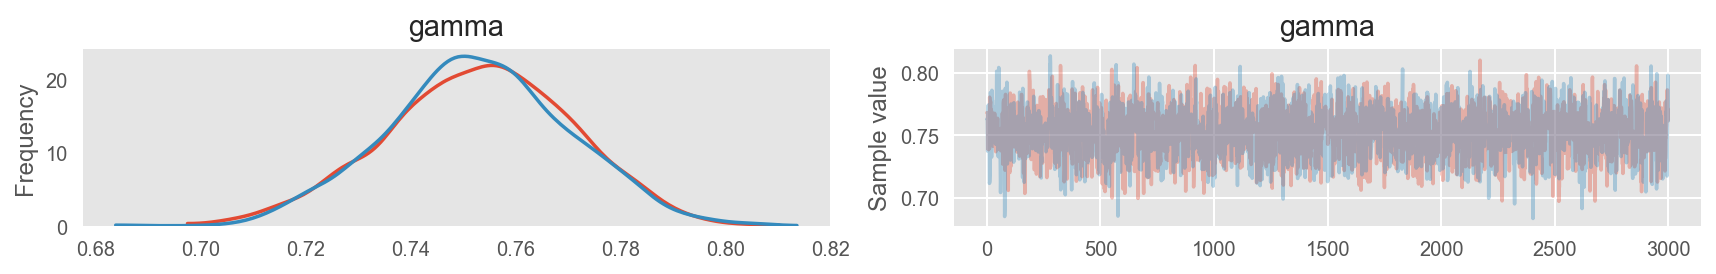

In [5]:
with pm.Model() as model1:
    gamma = pm.Uniform('gamma', lower=.5, upper=1)
    gammat = tt.stack([1-gamma, .5, gamma])
    yiq = pm.Bernoulli('yiq', p=gammat[tmat], observed=y)
    trace1 = pm.sample(3e3, njobs=2, tune=1000)
    
pm.traceplot(trace1)
plt.show()

100%|██████████| 100/100 [00:00<00:00, 134.45it/s]


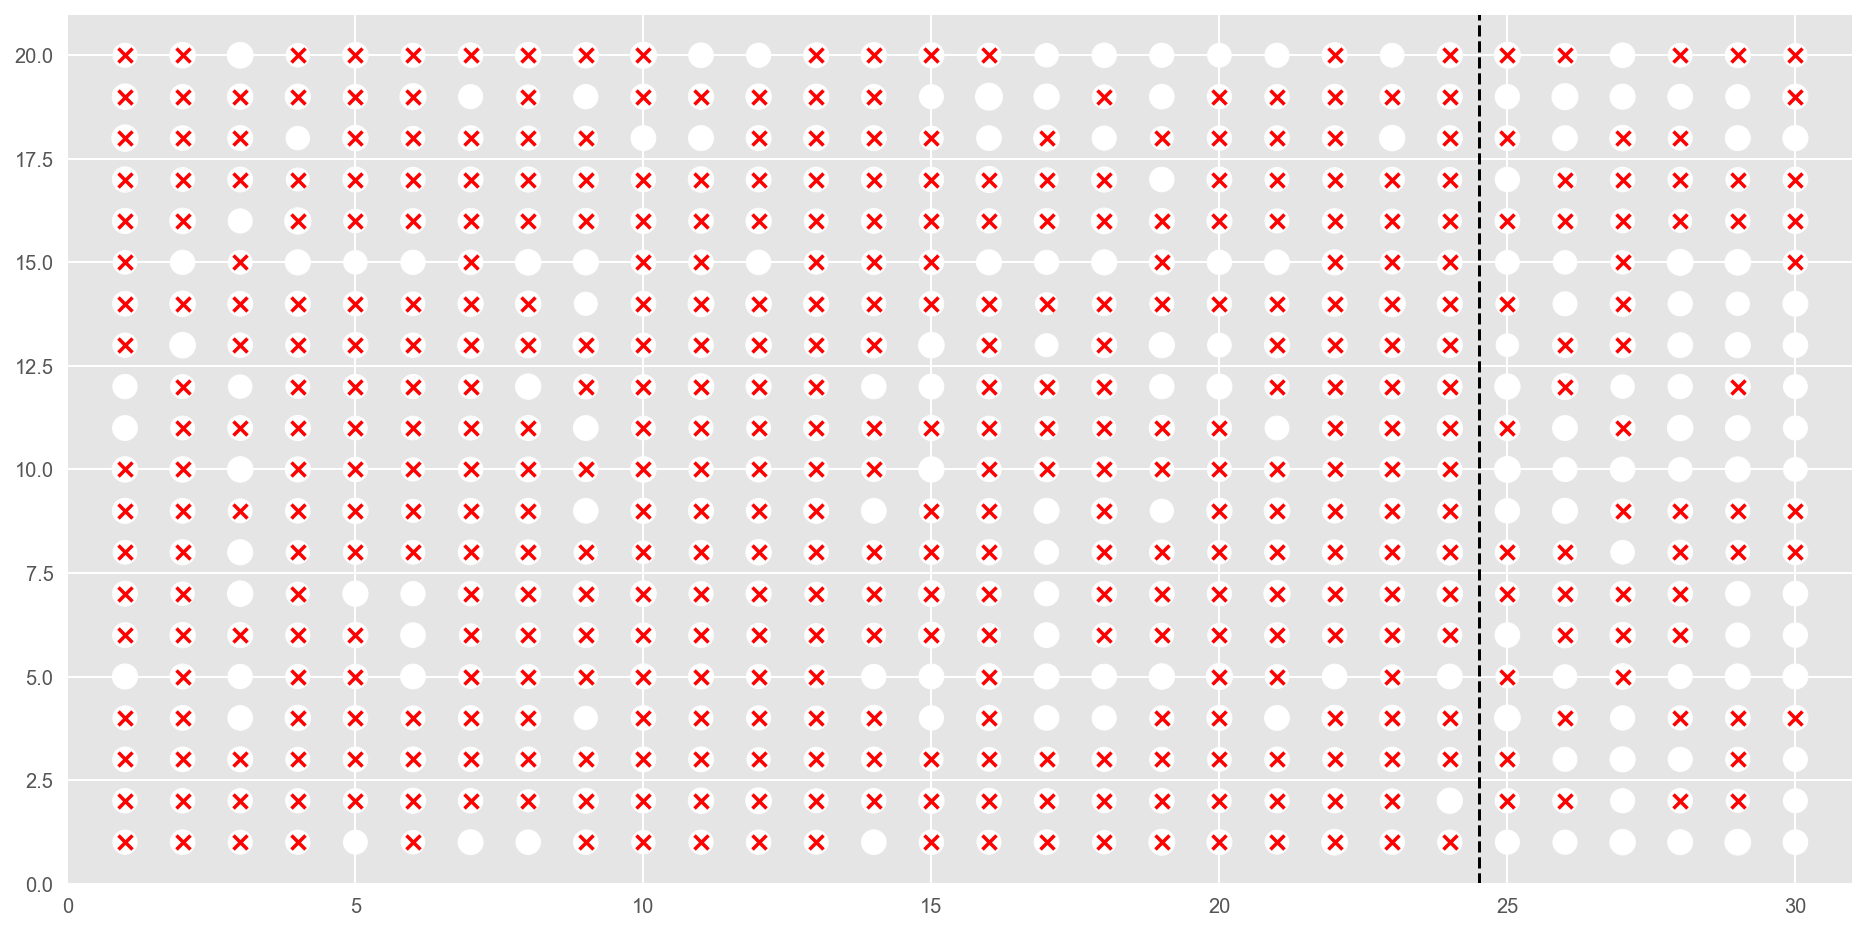

In [6]:
ppc = pm.sample_ppc(trace1, samples=100, model=model1)
yiqpred = np.asarray(ppc['yiq'])
fig = plt.figure(figsize=(16, 8))
x1 = np.repeat(np.arange(ns)+1, nq).reshape(ns, -1).flatten()
y1 = np.repeat(np.arange(nq)+1, ns).reshape(nq, -1).T.flatten()

plt.scatter(y1, x1, s=np.mean(yiqpred, axis=0)*200, c='w')
plt.scatter(y1[y.flatten() == 1], x1[y.flatten() == 1], marker='x', c='r')
plt.plot(np.ones(100)*24.5, np.linspace(0, 21, 100), '--', lw=1.5, c='k')
plt.axis([0, 31, 0, 21])
plt.show()

## 18.2 Stopping
A common comparison (e.g., Bergert & Nosofsky, 2007; Lee & Cummins, 2004) is between TTB and a model often called the Weighted ADDitive (WADD) model, which sums the evidence for both decision alternatives over all available cues, and chooses the one with the greatest evidence.

$$ \phi \sim \text{Uniform}(0,1)$$
$$ z_i \sim \text{Bernoulli}(\phi)$$
$$ \gamma \sim \text{Uniform}(0.5,1)$$  
$$ t_{iq} = 
\begin{cases}
\text{TTB}\,(\mathbf a_q,\mathbf b_q) & \text{if $z_i = 1$} \\
\text{WADD}\,(\mathbf a_q,\mathbf b_q) & \text{if $z_i = 0$} \\
\end{cases}  $$  

$$ y_{iq} \sim
\begin{cases}
\text{Bernoulli}(\gamma) & \text{if $t_{iq} = a$} \\
\text{Bernoulli}(1- \gamma) & \text{if $t_{iq} = b$} \\
\text{Bernoulli}(0.5) & \text{otherwise}
\end{cases}  $$

In [7]:
# Question cue contributions template
qcc = np.zeros((nq, nc))
for q in range(nq):
    # Add Cue Contributions To Mimic TTB Decision
    for j in range(nc):
        qcc[q, j] = (m[p[q, 0]-1, j]-m[p[q, 1]-1, j])

qccmat = np.tile(qcc[np.newaxis, :, :], (ns, 1, 1))
# TTB Model For Each Question
s = np.argsort(v)  # s[1:nc] <- rank(v[1:nc])
smat = np.tile(s[np.newaxis, :], (ns, nq, 1))
ttmp = np.sum(qccmat*np.power(2, smat), axis=2)
tmat = -1*(-ttmp > 0)+(ttmp > 0)+1
t = tmat[0]
# tmat = np.tile(t[np.newaxis, :], (ns, 1))        

# WADD Model For Each Question
xmat = np.tile(x[np.newaxis, :], (ns, nq, 1))
wtmp = np.sum(qccmat*xmat, axis=2)
wmat = -1*(-wtmp > 0)+(wtmp > 0)+1
w = wmat[0]

print(t)
print(w)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0]


Assigned NUTS to phi_logodds_
Assigned BinaryGibbsMetropolis to zi
Assigned NUTS to gamma_interval_
100%|██████████| 3000/3000.0 [00:22<00:00, 114.27it/s]


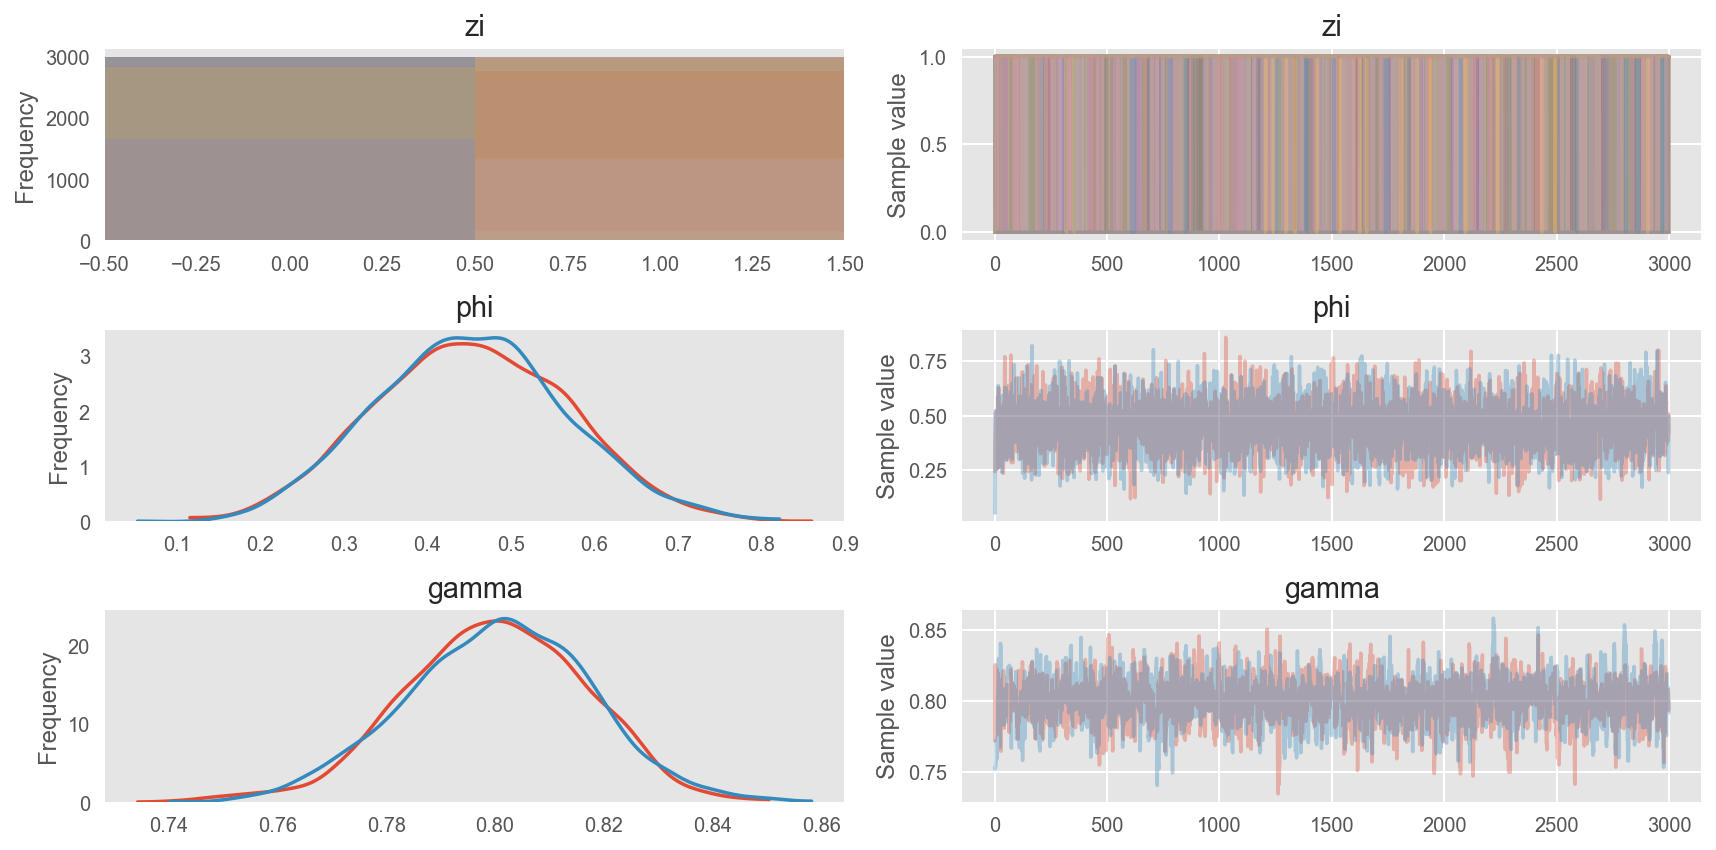

In [8]:
with pm.Model() as model2:
    phi = pm.Beta('phi', alpha=1, beta=1, testval=.01)
    
    zi = pm.Bernoulli('zi', p=phi, shape=ns,
                      testval=np.asarray([1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]))
    zi_ = tt.reshape(tt.repeat(zi, nq), (ns, nq))
    
    gamma = pm.Uniform('gamma', lower=.5, upper=1)
    gammat = tt.stack([1-gamma, .5, gamma])

    t2 = tt.switch(tt.eq(zi_, 1), tmat, wmat)
    yiq = pm.Bernoulli('yiq', p=gammat[t2], observed=y)

    trace2 = pm.sample(3e3, njobs=2, tune=1000)
    
pm.traceplot(trace2)
plt.show()

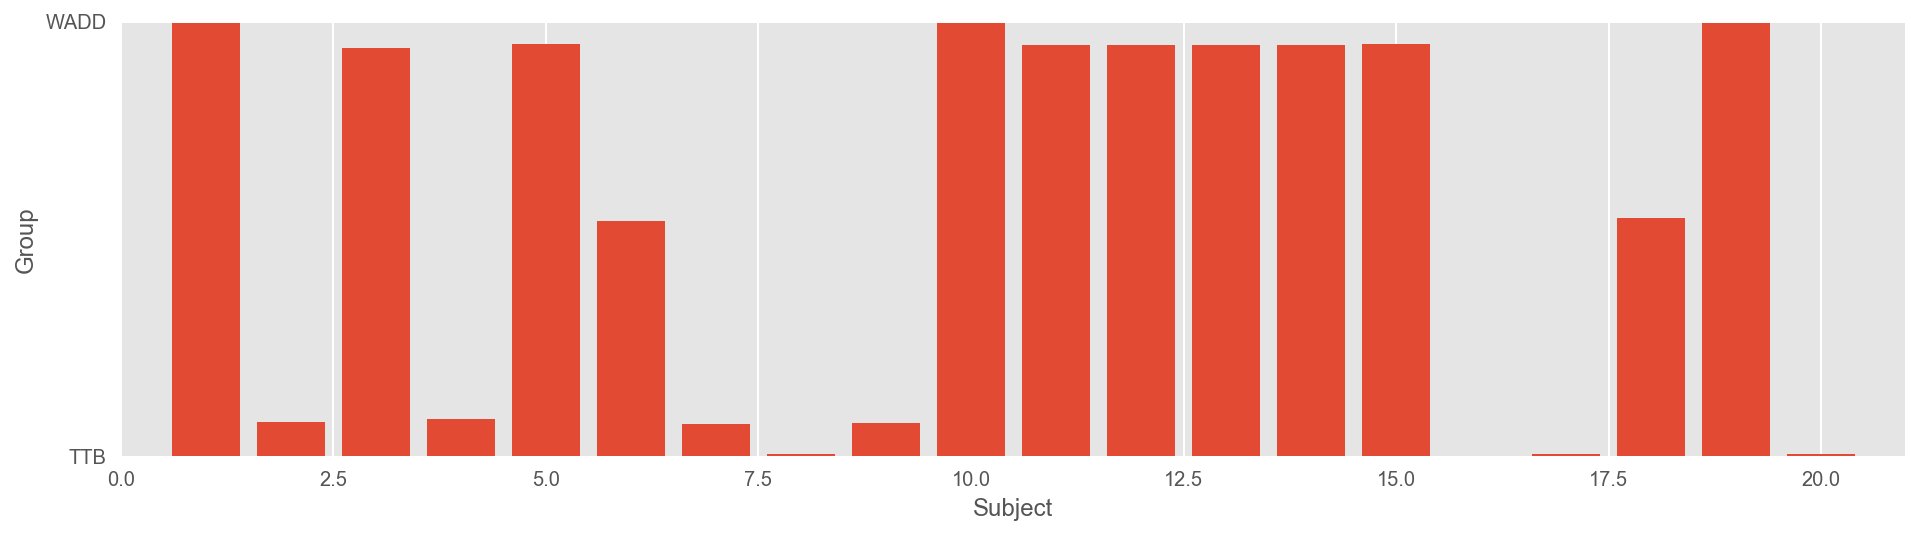

In [9]:
fig = plt.figure(figsize=(16, 4))
zitrc = trace2['zi'][1000:]
plt.bar(np.arange(ns)+1, 1-np.mean(zitrc, axis=0))
plt.yticks([0, 1], ('TTB', 'WADD'))
plt.xlabel('Subject')
plt.ylabel('Group')
plt.axis([0, 21, 0, 1])
plt.show()

## 18.3 Searching


$$ s_i \sim \text{Uniform}((1,...,9),...,(9,...,1))$$
$$ t_{iq} = \text{TTB}_{si}(\mathbf a_q,\mathbf b_q)$$
$$ \gamma \sim \text{Uniform}(0.5,1)$$  
$$ y_{iq} \sim
\begin{cases}
\text{Bernoulli}(\gamma) & \text{if $t_{iq} = a$} \\
\text{Bernoulli}(1- \gamma) & \text{if $t_{iq} = b$} \\
\text{Bernoulli}(0.5) & \text{otherwise}
\end{cases}  $$

In [14]:
with pm.Model() as model3:
    gamma = pm.Uniform('gamma', lower=.5, upper=1)
    gammat = tt.stack([1-gamma, .5, gamma])
    
    v1 = pm.HalfNormal('v1', sd=1, shape=ns*nc)    
    s1 = pm.Deterministic('s1', tt.argsort(v1.reshape((ns, 1, nc)), axis=2))
    smat2 = tt.tile(s1, (1, nq, 1))  # s[1:nc] <- rank(v[1:nc])
    
    # TTB Model For Each Question
    ttmp = tt.sum(qccmat*tt.power(2, smat2), axis=2)
    tmat = -1*(-ttmp > 0)+(ttmp > 0)+1
    
    yiq = pm.Bernoulli('yiq', p=gammat[tmat], observed=y)

It is important to notice here that, the sorting operation `s[1:nc] <- rank(v[1:nc])` is likely breaks the smooth property in geometry. Method such as NUTS and ADVI is likely return wrong estimation as the nasty geometry will lead the sampler to stuck in some local miminal.  
For this reason, we use Metropolis to sample from this model.

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pymc3/sampling.py:188: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically initialized. init argument ignored.')
100%|██████████| 100000/100000.0 [03:20<00:00, 498.24it/s]


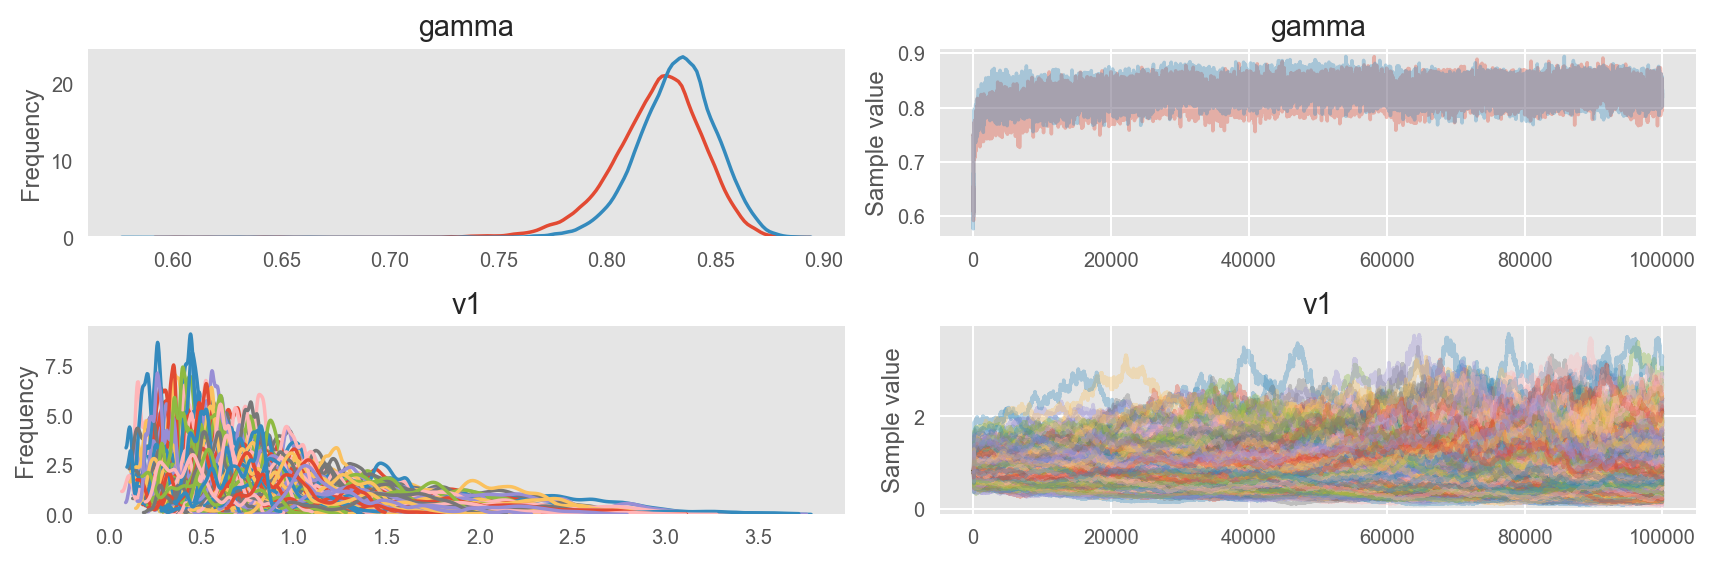

In [16]:
with model3:
    # trace3 = pm.sample(3e3, njobs=2, tune=1000)
    trace3 = pm.sample(1e5, step=pm.Metropolis(), njobs=2)

pm.traceplot(trace3, varnames=['gamma', 'v1'])
plt.show()

In [19]:
burnin = 50000
# v1trace = np.squeeze(trace3['v1'][burnin:])
# s1trace = np.argsort(v1trace, axis=2)
s1trace = np.squeeze(trace3[burnin:]['s1'])
for subj_id in [12, 13]:
    subj_s = np.squeeze(s1trace[:,subj_id-1,:])
    unique_ord = np.vstack({tuple(row) for row in subj_s})
    num_display = 10
    print('Subject %s' %(subj_id))
    print('There are %s search orders sampled in the posterior.'%(unique_ord.shape[0]))
    mass_ = []
    for s_ in unique_ord:
        mass_.append(np.mean(np.sum(subj_s == s_, axis=1) == len(s_)))
    mass_ = np.asarray(mass_)
    sortmass = np.argsort(mass_)[::-1]
    for i in sortmass[:num_display]:
        s_ = unique_ord[i]
        print('Order=(' + str(s_+1) + '), Estimated Mass=' + str(mass_[i]))

Subject 12
There are 237 search orders sampled in the posterior.
Order=([9 7 2 5 3 4 1 6 8]), Estimated Mass=0.05224
Order=([9 7 2 3 4 5 6 1 8]), Estimated Mass=0.04767
Order=([7 5 6 1 3 9 4 2 8]), Estimated Mass=0.04395
Order=([9 7 2 5 3 4 6 1 8]), Estimated Mass=0.03847
Order=([7 5 6 1 9 3 2 4 8]), Estimated Mass=0.03343
Order=([7 5 2 3 9 1 4 6 8]), Estimated Mass=0.02993
Order=([7 5 2 3 9 4 6 1 8]), Estimated Mass=0.02963
Order=([7 5 1 6 9 3 2 4 8]), Estimated Mass=0.02926
Order=([7 5 2 3 9 4 1 6 8]), Estimated Mass=0.02469
Order=([5 7 2 3 9 4 6 1 8]), Estimated Mass=0.02335
Subject 13
There are 124 search orders sampled in the posterior.
Order=([3 1 7 8 9 6 2 5 4]), Estimated Mass=0.10758
Order=([3 1 7 8 9 6 5 2 4]), Estimated Mass=0.09809
Order=([6 1 4 7 9 8 3 5 2]), Estimated Mass=0.06334
Order=([6 1 4 7 9 8 5 2 3]), Estimated Mass=0.05351
Order=([6 1 4 7 9 8 2 5 3]), Estimated Mass=0.05168
Order=([6 1 7 4 9 8 2 5 3]), Estimated Mass=0.04842
Order=([7 3 1 8 9 6 4 5 2]), Estimated

The return order is not at all similar to the result in JAGS (as shown in the book on p.233). However, the cue 2 is searched before cue 6 in Subject 12 and vice versa in Subject 13, which is the same as in the book.

## 18.4 Searching and stopping


$$ \phi_{i} \sim \text{Uniform}(0,1)$$
$$ z_{iq} \sim \text{Bernoulli}(\phi_{i})$$
$$ s_i \sim \text{Uniform}((1,...,9),...,(9,...,1))$$
$$ \gamma \sim \text{Uniform}(0.5,1)$$  
$$ t_{iq} = 
\begin{cases}
\text{TTB}_{si}\,(\mathbf a_q,\mathbf b_q) & \text{if $z_{iq} = 1$} \\
\text{WADD}\,(\mathbf a_q,\mathbf b_q) & \text{if $z_{iq} = 0$} \\
\end{cases}  $$  
$$ y_{iq} \sim
\begin{cases}
\text{Bernoulli}(\gamma) & \text{if $t_{iq} = a$} \\
\text{Bernoulli}(1- \gamma) & \text{if $t_{iq} = b$} \\
\text{Bernoulli}(0.5) & \text{otherwise}
\end{cases}  $$

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pymc3/sampling.py:188: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically initialized. init argument ignored.')
100%|██████████| 100000/100000.0 [02:29<00:00, 670.31it/s]


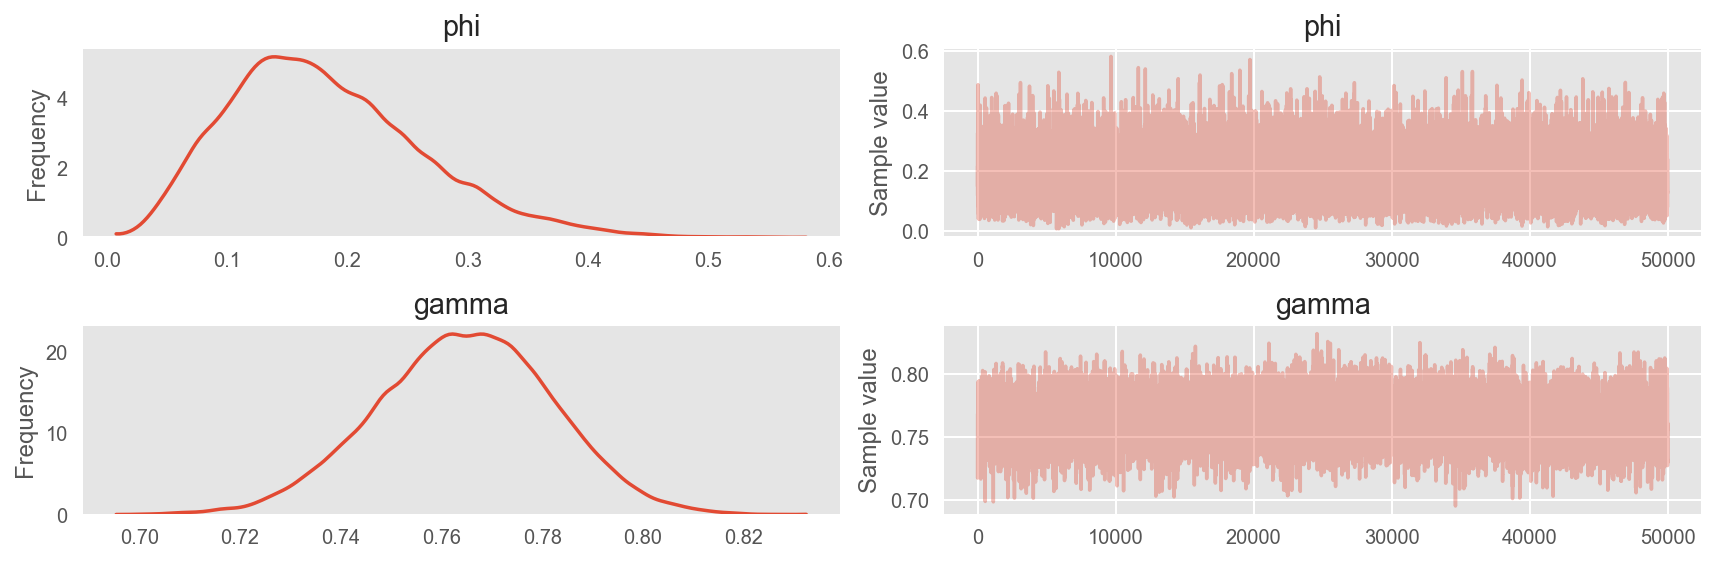

In [10]:
with pm.Model() as model4:
    phi = pm.Beta('phi', alpha=1, beta=1, testval=.01)
    
    zi = pm.Bernoulli('zi', p=phi, shape=ns,
                      testval=np.asarray([1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]))
    zi_ = tt.reshape(tt.repeat(zi, nq), (ns, nq))
    
    gamma = pm.Uniform('gamma', lower=.5, upper=1)
    gammat = tt.stack([1-gamma, .5, gamma])

    v1 = pm.HalfNormal('v1', sd=1, shape=ns*nc)    
    s1 = pm.Deterministic('s1', tt.argsort(v1.reshape((ns, 1, nc)), axis=2))
    smat2 = tt.tile(s1, (1, nq, 1))  # s[1:nc] <- rank(v[1:nc])
    
    # TTB Model For Each Question
    ttmp = tt.sum(qccmat*tt.power(2, smat2), axis=2)
    tmat = -1*(-ttmp > 0) + (ttmp > 0) + 1
            
    t2 = tt.switch(tt.eq(zi_, 1), tmat, wmat)
    yiq = pm.Bernoulli('yiq', p=gammat[t2], observed=y)
    
    trace4 = pm.sample(1e5, step=pm.Metropolis())
    
burnin=50000
pm.traceplot(trace4[burnin:], varnames=['phi', 'gamma']);

100%|██████████| 100/100 [00:01<00:00, 89.74it/s]


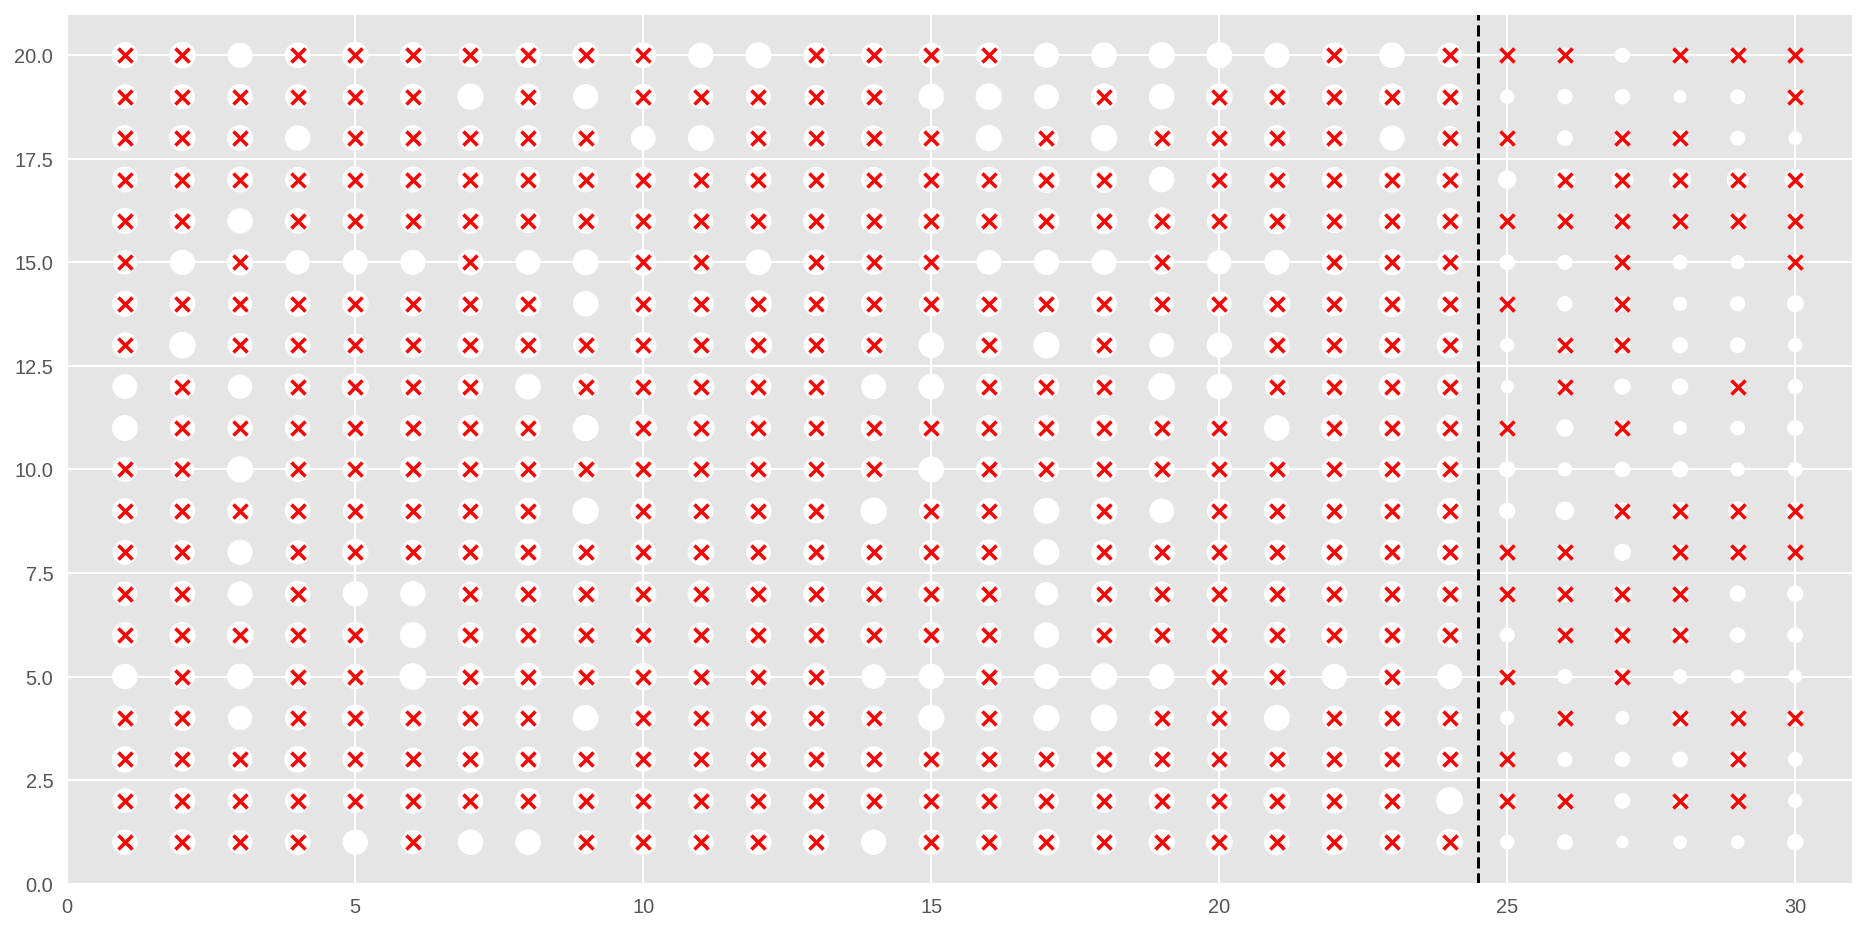

In [21]:
ppc = pm.sample_ppc(trace4[burnin:], samples=100, model=model4)
yiqpred = np.asarray(ppc['yiq'])
fig = plt.figure(figsize=(16, 8))
x1 = np.repeat(np.arange(ns)+1, nq).reshape(ns, -1).flatten()
y1 = np.repeat(np.arange(nq)+1, ns).reshape(nq, -1).T.flatten()

plt.scatter(y1, x1, s=np.mean(yiqpred, axis=0)*200, c='w')
plt.scatter(y1[y.flatten() == 1], x1[y.flatten() == 1], marker='x', c='r')
plt.plot(np.ones(100)*24.5, np.linspace(0, 21, 100), '--', lw=1.5, c='k')
plt.axis([0, 31, 0, 21])
plt.show()